In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

# Fungsi untuk mengurai XML Pascal VOC
def parse_voc_xml(xml_path):
    import xml.etree.ElementTree as ET
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    objects = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        objects.append((name,))
    return objects

# Fungsi untuk memuat dataset
def load_dataset(dataset_dir):
    images = []
    labels = []
    label_map = {'document': 0, 'KTP': 1, 'KK': 2, 'SIM': 3}  # Pemetaan label ke angka
    for folder in ["train", "test", "valid"]:
        folder_path = os.path.join(dataset_dir, folder)
        for file in os.listdir(folder_path):
            if file.endswith(".xml"):
                xml_path = os.path.join(folder_path, file)
                objects = parse_voc_xml(xml_path)
                if len(objects) > 0:  # Pastikan file XML memiliki objek
                    image_name = file.replace(".xml", "") + ".jpg"  # Asumsi file gambar memiliki nama yang sama dengan file XML
                    image_path = os.path.join(folder_path, image_name)
                    if os.path.exists(image_path):
                        img = cv2.imread(image_path)
                        if img is not None:
                            img = cv2.resize(img, (128, 128))
                            images.append(img)
                            labels.append(label_map[objects[0][0]])  # Konversi label string ke angka
                        else:
                            print(f"[Warning] Gambar tidak dapat dibaca: {image_path}")
                    else:
                        print(f"[Warning] Path gambar tidak ditemukan: {image_path}")
    return np.array(images), np.array(labels)

# Membuat model CNN
def create_model():
    input_layer = Input(shape=(128, 128, 3))
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(4, activation='softmax')(x)  # Sesuaikan jumlah kelas
    model = Model(inputs=input_layer, outputs=output)
    return model

# Memuat dataset
dataset_dir = "./dataset"
images, labels = load_dataset(dataset_dir)

# Konversi labels menjadi one-hot encoding
labels = tf.keras.utils.to_categorical(labels, num_classes=4)  # 4 adalah jumlah kelas

# Memastikan bentuk labels adalah 2D (None, num_classes)
print("Shape of labels after to_categorical:", labels.shape)

# Membagi dataset menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Memastikan dimensi dataset sebelum melatih
print("Shapes before training:")
print("X_train shape:", X_train.shape)  # Harus (batch_size, 128, 128, 3)
print("y_train shape:", y_train.shape)  # Harus (batch_size, num_classes)
print("X_test shape:", X_test.shape)    # Harus (batch_size, 128, 128, 3)
print("y_test shape:", y_test.shape)    # Harus (batch_size, num_classes)

# Membuat model
model = create_model()

# Menyusun model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

# Melatih model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

# Mengevaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Shape of labels after to_categorical: (627, 4)
Shapes before training:
X_train shape: (501, 128, 128, 3)
y_train shape: (501, 4)
X_test shape: (126, 128, 128, 3)
y_test shape: (126, 4)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 127008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    16,257,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,258,564 (62.02 MB)

 Trainable params: 16,258,564 (62.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - accuracy: 0.2527 - loss: 4379.1064 - val_accuracy: 0.3730 - val_loss: 1240.4159
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - accuracy: 0.5704 - loss: 514.0468 - val_accuracy: 0.4762 - val_loss: 127.8277
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - accuracy: 0.7409 - loss: 58.1728 - val_accuracy: 0.7222 - val_loss: 36.3865
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.8765 - loss: 11.5699 - val_accuracy: 0.7857 - val_loss: 24.0079
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.9513 - loss: 3.2357 - val_accuracy: 0.7063 - val_loss: 28.8994
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - accuracy: 0.9459 - loss: 3.4651 - val_accuracy: 0.8016 - val_loss: 22.1758
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - accuracy: 0.9873 - loss: 0.4258 - val_accuracy: 0.8175 - val_loss: 21.7945
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - accuracy: 0.9936 - loss: 0.2631 -

In [22]:
# Mengonversi model ke format .tflite
def save_tflite_model(model, output_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(output_path, 'wb') as f:
        f.write(tflite_model)
    print(f"Model berhasil disimpan sebagai {output_path}")

# Simpan model ke dalam file .tflite
save_tflite_model(model, "model_klasifikasi.tflite")

INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmpfiept9bo\assets


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmpfiept9bo\assets


Saved artifact at 'C:\Users\ACER\AppData\Local\Temp\tmpfiept9bo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_12')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2128545668112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2128545671184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2128545670032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2128545667920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2127251543568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2127251544144: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasil disimpan sebagai model_klasifikasi.tflite


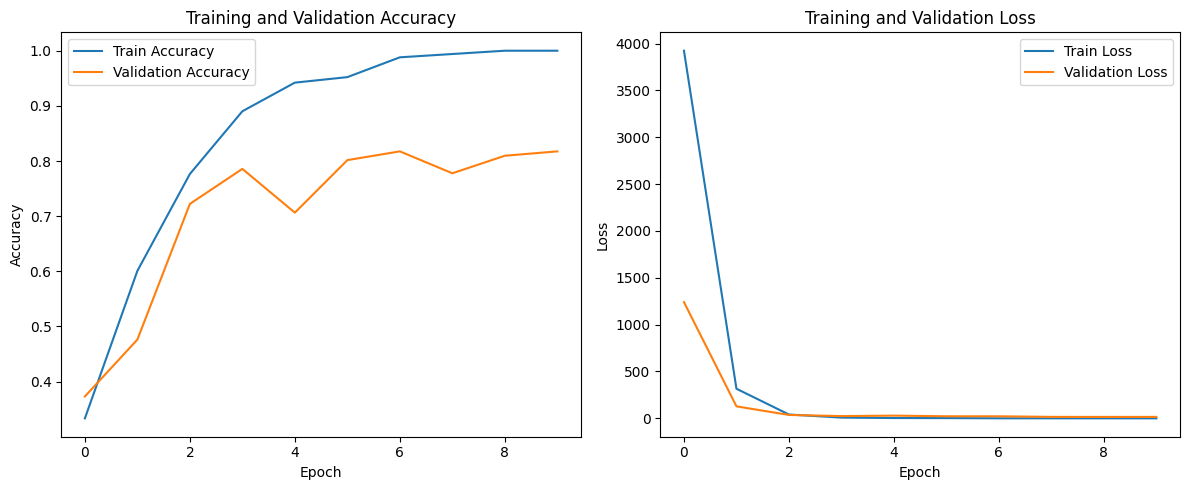

In [36]:
import matplotlib.pyplot as plt

# Memvisualisasikan hasil pelatihan
def plot_training_history(history):
    # Plot akurasi
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk menampilkan plot
plot_training_history(history)

In [37]:
import tensorflow as tf
import cv2
import numpy as np

# Fungsi untuk memuat model .tflite
def load_tflite_model(tflite_path):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()
    return interpreter

# Fungsi untuk melakukan preprocessing pada gambar
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Gambar tidak dapat dibaca dari path: {image_path}")
    img = cv2.resize(img, (128, 128))
    img = img.astype('float32') / 255.0  # Normalisasi
    img = np.expand_dims(img, axis=0)  # Tambahkan batch dimension
    return img

# Fungsi untuk menjalankan prediksi menggunakan model .tflite
def predict_image(tflite_model_path, image_path, label_map):
    # Memuat model .tflite
    interpreter = load_tflite_model(tflite_model_path)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Preprocessing gambar
    input_data = preprocess_image(image_path)

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Jalankan model
    interpreter.invoke()

    # Ambil hasil prediksi
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_label = np.argmax(output_data)
    confidence = np.max(output_data)

    # Tampilkan hasil
    label_name = [k for k, v in label_map.items() if v == predicted_label][0]
    print(f"Prediksi: {label_name} (Confidence: {confidence:.2f})")


In [ ]:
# Label mapping (sama dengan yang digunakan saat melatih model)
label_map = {'document': 0, 'KTP': 1, 'KK': 2, 'SIM': 3}

# Path model .tflite dan gambar
tflite_model_path = "model_klasifikasi.tflite"
image_path = "./dataset/test/WhatsApp Image 2024-11-19 at 17.39.41_2639f3e1.jpg"  # Ganti dengan path gambar yang ingin diuji

# Jalankan prediksi
predict_image(tflite_model_path, image_path, label_map)

Prediksi: KTP (Confidence: 0.99)
